In [1]:
import pandas as pd
import math
import numpy as np
import copy
import warnings
import gc
from sklearn import preprocessing
warnings.filterwarnings('ignore')
feature_path ='./feature/'
res_path = './res/'
data_path = './data/'
second_round_path = './second round/'

In [2]:
transaction_df = pd.read_csv(data_path+'transaction_train_new.csv')
operation_df =  pd.read_csv(data_path+'operation_train_new.csv')
label= pd.read_csv(data_path+'tag_train_new.csv')

# transaction_test = pd.read_csv(data_path+'transaction_round1_new.csv')
# operation_test = pd.read_csv(data_path+'operation_round1_new.csv')
transaction_test = pd.read_csv(second_round_path+'test_transaction_round2.csv')
operation_test = pd.read_csv(second_round_path+'test_operation_round2.csv')
sample = pd.read_csv(data_path+'sample.csv')
# operation_df = pd.merge(operation_df,label,on = 'UID',how='left')

In [3]:
def merge_count(df1,df2,columns,value,cname):
    add = df1.groupby(columns)[value].count().reset_index().rename(columns = {value:cname})
    df2=df2.merge(add,on=columns,how="left")
    del add
    gc.collect()
    return df2

def merge_nunique(df1,df2,columns,value,cname):
    add = df1.groupby(columns)[value].nunique().reset_index().rename(columns = {value:cname})
    df2=df2.merge(add,on=columns,how="left")
    del add
    gc.collect()
    return df2

def merge_value_count(df1,df2,col,value):
    tmp = df1.groupby(col)[value].count().reset_index().rename(columns = {value:'cnt'})
    df = tmp.pivot(index=col[0],columns=col[1],values='cnt').reset_index()
    cname = [col[0]]
    for index in range(1,len(df.columns)):
        cname.append(str(col[1])+'_'+str(df.columns[index]))
    df.columns=cname
    df = df.fillna(0)
    df2 = df2.merge(df,on=str(col[0]),how='left')
    del df,df1
    gc.collect()
    return df2

In [4]:
def get_tag_rate(df,columns,cname):
    op_train = pd.merge(df, label, on = 'UID', how = 'left')
    t_op_data = op_train[op_train['Tag'] == 0]
    f_op_data = op_train[op_train['Tag'] == 1]
    t_op_sample = t_op_data.sample(frac = 0.2, random_state = 88)
    f_op_sample = f_op_data.sample(frac = 0.2, random_state = 88)
    sample_data = pd.concat([t_op_sample,f_op_sample])
    t_rate_op = sample_data.groupby(columns)['Tag'].mean().reset_index().rename(columns = {'Tag': cname})
    t_rate_op[cname] = (t_rate_op[cname]*100).astype(int)
    
#     t_rate_op[cname] = pd.cut(t_rate_op[cname],bins = [-1,0,1,2,9,14,20,35,50,100],labels = False)
    gc.collect()
    return t_rate_op

mode_tag_rate = get_tag_rate(operation_df,'mode','mode_Tag_rate')

In [5]:
# add = operation_df.groupby('mode')['Tag'].mean().reset_index().rename(columns = {'Tag':'mode_Tag_rate'})
# add.mode_Tag_rate = (add.mode_Tag_rate*100).astype(int)
# add.mode_Tag_rate = pd.cut(add.mode_Tag_rate,bins = [-1,0,1,2,9,14,20,35,50,100],labels = False)
op_df = operation_df.merge(mode_tag_rate,on='mode',how="left")
op_test = operation_test.merge(mode_tag_rate,on='mode',how="left")

In [6]:
op_train = pd.merge(operation_df, label, on = 'UID', how = 'left')
add = op_train.groupby('day')['Tag'].mean().reset_index().rename(columns = {'Tag':'day_Tag_rate'})
add.day_Tag_rate = (add.day_Tag_rate*100).astype(int)
#add.day_Tag_rate = pd.cut(add.day_Tag_rate,bins = [-1,6,11,13,100],labels = False)


In [7]:
operation_df = operation_df.merge(add,on='day',how="left")
operation_test = operation_test.merge(add,on='day',how="left")

(array([469869., 157750.,  19769., 635007.,  39241.,  23851.,  34534.,
         36195.,      0.,  44627.]),
 array([ 4. ,  6.3,  8.6, 10.9, 13.2, 15.5, 17.8, 20.1, 22.4, 24.7, 27. ]),
 <a list of 10 Patch objects>)

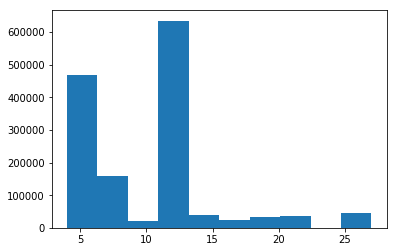

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(operation_df.day_Tag_rate)

In [9]:
operation_df.groupby('UID')['day'].value_counts().unstack().reset_index().shape

(29728, 31)

In [10]:
def get_rate(df,columns,cname,bins=[-1,0,8,20,30,40,50,60,70,80,90,99,100]):
    tt_train = pd.merge(df, label, on = 'UID', how = 'left')
    rate = tt_train.groupby(columns)['Tag'].mean().reset_index().rename(columns = {'Tag':cname})
    rate[cname] = pd.cut((rate[cname]*100).astype(int),bins,labels=False)
    gc.collect()
    return rate
merchant_tag_rate = get_rate(transaction_df,'merchant','merchant_Tag_rate',bins=[-1,0,8,20,30,40,50,60,70,80,90,99,100])
transaction_df = transaction_df.merge(merchant_tag_rate,on='merchant',how="left")
transaction_test = transaction_test.merge(merchant_tag_rate,on='merchant',how="left")    

In [11]:
def cut_day2week(df,cname,bins = [0,7,14,21,28,31]):
    df[cname] = pd.cut(df['day'],bins,labels=False)
    return df
tr_df = cut_day2week(transaction_df,'week',bins = [0,7,14,21,28,31])
tr_test = cut_day2week(transaction_test,'week',bins = [0,5,12,19,26,31])  

In [12]:
def get_op_fea(operation_df):
    #op_day
    op_fea = operation_df[['UID']].drop_duplicates()
    tmp = operation_df.groupby('UID')['day'].agg([max,min,np.mean]).reset_index()
    tmp.columns=['UID','op_day_max','op_day_min','op_day_mean']
    op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
    op_fea = merge_count(operation_df,op_fea,'UID','day','op_cnt')
    
# #     #1104,1
#     tmp1 = operation_df.groupby('UID')['day'].value_counts().rename('day_counts').reset_index()
#     tmp = tmp1.groupby('UID').day_counts.agg([max,min,np.mean,np.std]).reset_index()
#     tmp.columns=['UID','op_day_counts_max','op_day_counts_min','op_day_counts_mean','op_day_counts_std']
#     op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
#     del tmp1
    
#     1104,1 
#     tmp1 = tmp['UID']
#     tmp = (tmp[['op_day_counts_max','op_day_counts_min']]*100).\
#             apply(lambda x: x/operation_df.groupby('UID').day.count().values,axis=0)
#     tmp['UID'] = tmp1
#     tmp.columns=['UID','op_day_counts_max_r','op_day_counts_min_r']
#     op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
    
#     op_fea = merge_nunique(operation_df,op_fea,'UID','day','op_day_nunique')
#     op_fea['day_variety/sum'] = op_fea.op_day_nunique*100/op_fea.op_cnt
#     #1205，1
#     op_fea['op_day_counts_max-min'] = op_fea.op_day_counts_max-op_fea.op_day_counts_min
    
    #op_mode count
    #op_fea = merge_count(operation_df,op_fea,'UID','mode','op_cnt')
    op_fea = merge_nunique(operation_df,op_fea,'UID','mode','op_mode_nunique')
    #1104，1
    op_fea['mode_variety/sum'] = op_fea.op_mode_nunique*100/op_fea.op_cnt
    
    #success count
    op_fea = merge_count(operation_df[operation_df.success==0],op_fea,'UID','mode','op_fail_cnt')
    op_fea = merge_count(operation_df[operation_df.success==1],op_fea,'UID','mode','op_success_cnt')
    op_fea['op_fail_cnt'] = op_fea['op_fail_cnt'].fillna(0)
    op_fea['op_success_cnt'] = op_fea['op_success_cnt'].fillna(0)
    1104,1
    op_fea['op_success_rate'] = op_fea.op_success_cnt*100/op_fea.op_cnt
    
    #op_time
    operation_df['op_hour'] = operation_df['time'].apply(lambda x:int(x.split(':')[0]))
    tmp = operation_df.groupby('UID')['op_hour'].agg([max,min,np.mean]).reset_index()
    tmp.columns=['UID','op_hour_max','op_hour_min','op_hour_mean']
    op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
#     '''1104,2'''
    tmp1 = operation_df.groupby('UID')['op_hour'].value_counts().rename('hour_counts').reset_index()
    tmp = tmp1.groupby('UID').hour_counts.agg([max,min,np.mean,np.std]).reset_index()
    tmp.columns=['UID','op_hour_counts_max','op_hour_counts_min','op_hour_counts_mean','op_hour_counts_std']
    op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
    
    

    
    #op_device1
    for col in ['os','version','device1','device2','device_code1','device_code2','mac1','ip1','ip2',\
                'device_code3','mac2','wifi','geo_code','ip1_sub','ip2_sub']:
        op_fea = merge_nunique(operation_df,op_fea,'UID',col,'op_'+col+'_nunique')

    #op_os
#     1104,2有效
    op_fea['op_cnt/nunique'] = 1.0*op_fea.op_cnt/op_fea.op_os_nunique
                
    #1205，1
    op_fea['op_ip1/device1'] = 100*op_fea.op_ip1_nunique/op_fea.op_device1_nunique
    op_fea['op_device1/device_code1'] = 100*op_fea.op_device1_nunique/op_fea.op_device_code1_nunique
    
    '''1205,2'''
    tmp = operation_df.groupby('UID')['mode_Tag_rate'].value_counts().unstack().reset_index()
    tmp.fillna(0,inplace=True)
    op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
#     op_fea = pd.merge(op_fea,operation_df.groupby('UID')['os'].value_counts().\
#                       unstack().reset_index(),on='UID',how='left')
# '''day_rate无效'''
#     tmp = operation_df.groupby('UID')['day_Tag_rate'].value_counts().unstack().reset_index()
#     tmp.fillna(0,inplace=True)
#     op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
    
##     '''1106,1'''
    
#     tmp1 = operation_df.groupby('UID')['mode'].value_counts().rename('mode_counts').reset_index()
#     tmp = tmp1.groupby('UID').mode_counts.agg([max,min,np.mean,np.std]).reset_index()
#     tmp.columns=['UID','op_mode_counts_max','op_mode_counts_min','op_mode_counts_mean','op_mode_counts_std']
#     op_fea = pd.merge(op_fea,tmp,on='UID',how='left')
    gc.collect()
    return op_fea

In [13]:
def get_trans_fea(transaction_df):
    trans_fea = transaction_df[['UID']].drop_duplicates()
    #trans_channel
    trans_fea = merge_value_count(transaction_df,trans_fea,['UID','channel'],'day')
    trans_fea = merge_count(transaction_df,trans_fea,'UID','channel','trans_cnt')
    trans_fea = merge_nunique(transaction_df,trans_fea,'UID','channel','trans_channel_nunique')
    
    #day
    tmp = transaction_df.groupby('UID')['day'].agg([max,min,np.mean]).reset_index()
    tmp.columns=['UID','transaction_day_max','transaction_day_min','transaction_day_mean']
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    
#     #1105,2
#     tmp1 = transaction_df.groupby('UID')['day'].value_counts().rename('day_counts').reset_index()
#     tmp = tmp1.groupby('UID').day_counts.agg([max,min,np.mean,np.std]).reset_index()
#     tmp.columns=['UID','trans_day_counts_max','trans_day_counts_min','trans_day_counts_mean','trans_day_counts_std']
#     trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
#     del tmp1
#     1105,2 
#     tmp1 = tmp['UID']
#     tmp = (tmp[['trans_day_counts_max','trans_day_counts_min']]*100).\
#             apply(lambda x: x/transaction_df.groupby('UID').day.count().values,axis=0)
#     tmp['UID'] = tmp1
#     tmp.columns=['UID','trans_day_counts_max_r','trans_day_counts_min_r']
#     trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')

#     trans_fea = merge_nunique(transaction_df,trans_fea,'UID','day','trans_day_nunique')
#     trans_fea['day_variety/sum'] = trans_fea.trans_day_nunique*100/trans_fea.trans_cnt
##    1205，1
#     trans_fea['trans_day_counts_max-min'] = trans_fea.trans_day_counts_max-trans_fea.trans_day_counts_min

    #time
    transaction_df['trans_hour'] = transaction_df['time'].apply(lambda x:int(x.split(':')[0]))
    tmp = transaction_df.groupby('UID')['trans_hour'].agg([max,min,np.mean]).reset_index()
    tmp.columns=['UID','trans_hour_max','trans_hour_min','trans_hour_mean']
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
# # 1105,2
#     tmp1 = transaction_df.groupby('UID')['trans_hour'].value_counts().rename('hour_counts').reset_index()
#     tmp = tmp1.groupby('UID').hour_counts.agg([max,min,np.mean,np.std]).reset_index()
#     tmp.columns=['UID','trans_hour_counts_max','trans_hour_counts_min','trans_hour_counts_mean','trans_hour_counts_std']
#     trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    
    #trans_amt
    tmp = transaction_df.groupby('UID')['trans_amt'].agg([max,min,np.mean,np.sum]).reset_index()
    tmp.columns=['UID','transaction_amt_max','transaction_amt_min','transaction_amt_mean','transaction_amt_sum']
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
# #     #1105,2
#     max_min = lambda x: abs(max(x)-min(x))
#     tmp = transaction_df.groupby('UID')['trans_amt'].agg([np.std,max_min]).reset_index()
#     tmp.columns=['UID','transaction_amt_std','transaction_amt_max-min']
#     trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    
    #amt_src1
    trans_fea = merge_nunique(transaction_df,trans_fea,'UID','amt_src1','trans_amt_src1_nunique')
    #bal
    tmp = transaction_df.groupby('UID')['bal'].agg([max,min,np.mean,np.sum]).reset_index()
    tmp.columns=['UID','transaction_bal_max','transaction_bal_min','transaction_bal_mean','transaction_bal_sum']
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')

    #trans_type1 trans_type2
    for col in ['trans_type2','market_type']:
        trans_fea = merge_value_count(transaction_df,trans_fea,['UID',col],'day')
        trans_fea = merge_nunique(transaction_df,trans_fea,'UID',col,'trans_'+col+'_nunique')
    for col in ['trans_type1','merchant','code1','code2','acc_id1','device_code1','device_code2',\
                'device_code3','device1','device2','mac1','ip1','acc_id2','acc_id3','geo_code','market_code','ip1_sub']:
        trans_fea = merge_nunique(transaction_df,trans_fea,'UID',col,'trans_'+col+'_nunique')
        
    '''1108,1,线下非常有效'''    
#     trans_fea = merge_value_count(transaction_df,trans_fea,['UID','merchant_Tag_rate'],'day')#,线下非常有效,线上超级过拟合
    tmp = transaction_df.groupby('UID')['merchant_Tag_rate'].value_counts().unstack().reset_index()
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    
    '''1109,1'''
#     tmp = transaction_df.groupby('UID').day.value_counts().unstack(fill_value=0).reset_index()
#     trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
#     transaction_df['week'] = pd.cut(transaction_df.day,bins = [0,7,14,21,28,31],labels=False)
    tmp = transaction_df.groupby('UID').week.value_counts().unstack(fill_value=0).reset_index()
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    tmp = transaction_df.groupby(['UID','week']).day.value_counts().rename('week_day_count').reset_index()
    maxmin = lambda x: max(x)-min(x)
    tmp = tmp.pivot_table(index = 'UID',columns = 'week',values = 'week_day_count',aggfunc= [max,min,np.std,maxmin]).reset_index()
    tmp.fillna(-1,inplace=True)
    trans_fea = pd.merge(trans_fea,tmp,on='UID',how='left')
    
    '''1112,01'''
    
    gc.collect()
    return trans_fea

In [14]:
op_fea = get_op_fea(op_df)
trans_fea = get_trans_fea(transaction_df)

In [15]:
op_fea_test = get_op_fea(op_test)
trans_fea_test = get_trans_fea(tr_test)

In [16]:
trans_fea.shape

(30542, 85)

In [17]:
op_fea.to_csv("./data/feature/op_fea.csv")
trans_fea.to_csv("./data/feature/trans_fea.csv")

op_fea_test.to_csv("./data/feature/op_fea_test.csv")
trans_fea_test.to_csv("./data/feature/trans_fea_test.csv")

In [26]:
train_features = op_fea.merge(trans_fea, on='UID', how='outer')
train_data = train_features.merge(label,on='UID',how='left')
train_data = train_data.drop('UID', axis=1)
test_features = op_fea_test.merge(trans_fea_test, on='UID', how='outer').sort_values(['UID'])


UIDs = test_features['UID']
test_features = test_features.drop('UID', axis=1)

# columns_to_drop = [col for col in train_data.columns if col not in test_features.columns and col != 'Tag']
# train_data = train_data.drop(columns_to_drop, axis=1)
# columns_to_drop = [col for col in test_features.columns if col not in train_data.columns and col != 'Tag']
# test_features = test_features.drop(columns_to_drop, axis=1)

#Fill nan with average
train_data = train_data.fillna(train_data.mean())
test_features = test_features.fillna(train_data.drop('Tag', axis=1).mean())


columns_to_drop = [col for col in train_data.columns if col not in test_features.columns and col != 'Tag']
train_data = train_data.drop(columns_to_drop, axis=1)
columns_to_drop = [col for col in test_features.columns if col not in train_data.columns and col != 'Tag']
test_features = test_features.drop(columns_to_drop, axis=1)

In [27]:
def tpr_scorer(estimator, x, y_true):
    y_predict = estimator.predict_proba(x)[:, 1]
    d = pd.DataFrame()
    d['prob'] = list(y_predict)
    d['y'] = list(y_true)
    d = d.sort_values(['prob'], ascending=[0])
    y = d.y
    
    PosAll = pd.Series(y).value_counts()[1]
    NegAll = pd.Series(y).value_counts()[0]
    pCumsum = d['y'].cumsum()
    nCumsum = np.arange(len(y)) - pCumsum + 1
    pCumsumPer = pCumsum / PosAll
    nCumsumPer = nCumsum / NegAll
    TR1 = pCumsumPer[abs(nCumsumPer-0.001).idxmin()]
    TR2 = pCumsumPer[abs(nCumsumPer-0.005).idxmin()]
    TR3 = pCumsumPer[abs(nCumsumPer-0.01).idxmin()]
    return 0.4 * TR1 + 0.3 * TR2 + 0.3 * TR3

In [28]:
import sklearn.model_selection
import sklearn.metrics
import lightgbm as lgb
import sklearn.ensemble
import xgboost as xgb

def cv(x, y, params={}, splits=5):
    clf = lgb.LGBMClassifier(**params)
#     clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
#     clf = xgb.XGBClassifier(**params)
    kfold = sklearn.model_selection.StratifiedKFold(splits, shuffle=True)
    cv_score = sklearn.model_selection.cross_validate(clf, x, y, cv=kfold, scoring={
        'tpr': tpr_scorer,
        'accuracy': 'accuracy',
        'f1': 'f1_micro',
        'roc_auc': 'roc_auc'
    }, return_train_score=True)
    return cv_score

In [29]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        "num_leaves": 200,
        "max_depth": -1,
        "learning_rate": 0.1,
        'min_child_samples': 100,
        'n_estimators': 2000,
        'learning_rate': 0.05,
        'scale_pos_weight': float(label[label.Tag==0].shape[0]) / label[label.Tag==1].shape[0],
        'boost_from_average': True,
        'min_child_weight': 1e-3,
        "subsample_for_bin": 20000,
        'max_bin': 512,
        "metric": 'auc',
        'reg_alpha': 3,
        'reg_lambda': 5,
        'subsample': 0.9,
        'colsample_bytree':0.7, 
        'subsample_freq': 1,
        'n_jobs': -1,
}

def run_cross_validation(x, y):
    cv_result = cv(x, y, params=params, splits=5)
    for scorer, score in cv_result.items():
        print('%s: %s' % (scorer, score))
        print('Average %s: %f' % (scorer, score.mean()))

In [30]:
run_cross_validation(train_data.drop('Tag', axis=1).fillna(train_data.drop('Tag', axis=1).mean()).values, train_data.loc[:, 'Tag'].values)


fit_time: [14.41619611 13.58223009 11.02795601 15.91861916 18.26247501]
Average fit_time: 14.641495
score_time: [0.85873365 0.90235806 0.69390106 1.03280997 0.86306977]
Average score_time: 0.870175
test_tpr: [0.7529755  0.77409568 0.76429405 0.76091015 0.75005834]
Average test_tpr: 0.760467
train_tpr: [1. 1. 1. 1. 1.]
Average train_tpr: 1.000000
test_accuracy: [0.96327774 0.9642399  0.96183451 0.96391918 0.961668  ]
Average test_accuracy: 0.962988
train_accuracy: [0.99983963 0.99991982 0.99967927 0.99987973 0.99963919]
Average train_accuracy: 0.999792
test_f1: [0.96327774 0.9642399  0.96183451 0.96391918 0.961668  ]
Average test_f1: 0.962988
train_f1: [0.99983963 0.99991982 0.99967927 0.99987973 0.99963919]
Average train_f1: 0.999792
test_roc_auc: [0.97075276 0.97386938 0.97153284 0.97100483 0.9687575 ]
Average test_roc_auc: 0.971183
train_roc_auc: [0.99999999 1.         0.99999997 0.99999997 0.99999995]
Average train_roc_auc: 1.000000


In [31]:
def train(x, y, params={}):
    clf = lgb.LGBMClassifier(**params)
#     clf = xgb.XGBClassifier(**params)
    clf.fit(x, y)
    return clf

In [32]:
model = train(train_data.drop('Tag', axis=1).values, train_data.loc[:, 'Tag'].values, params=params)

In [33]:
result = model.predict_proba(test_features.values)[:, 1]

In [34]:
(result > 0.5).sum() / len(result)

0.2747562365455236

In [35]:
tpr_scorer(model, train_data.drop('Tag', axis=1).fillna(train_data.drop('Tag', axis=1).mean()).values, train_data.loc[:, 'Tag'].values)

1.0

In [36]:
result_frame = pd.DataFrame()
result_frame['UID'] = UIDs
result_frame['Tag'] = result

In [37]:

result_frame.to_csv(res_path + 'fres.csv', index=False)

In [42]:
train_features.columns

Index([             'UID',       'op_day_max',       'op_day_min',
            'op_day_mean',           'op_cnt',  'op_mode_nunique',
       'mode_variety/sum',      'op_fail_cnt',   'op_success_cnt',
        'op_success_rate',
       ...
               ('std', 0),         ('std', 1),         ('std', 2),
               ('std', 3),         ('std', 4),    ('<lambda>', 0),
          ('<lambda>', 1),    ('<lambda>', 2),    ('<lambda>', 3),
          ('<lambda>', 4)],
      dtype='object', length=143)